In [24]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

# 1. Segmentación

El objetivo principal de esta tarea es segmentar a los clientes en grupos distintos y homogéneos, con el fin de obtener un conocimiento más profundo de nuestra base de clientes y mejorar la estrategia comercial. 

El análisis de los clusters permitirá identificar patrones y características clave de cada grupo, lo que facilitará la orientación de nuestras acciones comerciales de manera más efectiva. Los resultados de esta segmentación se presentarán con una descripción clara y visual de cada cluster, destacando las diferencias entre ellos.

---

Carga de los dataset ya limpios que se encuentran en s3 de AWS, se unen y se genera un nuevo dataset que se guarda en igual en s3 de AWS para su uso directo.

In [25]:

# productos
prod_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/prod_df_cleaned.parquet") 

# sociodemografico
sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_adrian.parquet')

# comercial activity clean
ca_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/commercial_activity_df_clean.parquet") 



# merge de los tres dataframes
df_1_merge = pd.merge(prod_df_cleaned, sdg_df_cleaned, how="inner" ,on=['pk_cid','pk_partition'])

df_2_merge = pd.merge(df_1_merge,ca_df_cleaned, how="inner",on=['pk_cid','pk_partition'])

df_full_cleaned = df_2_merge.copy()

#df_full_cleaned.to_parquet("/Users/claudiacastro/df_full_cleaned.parquet")

Este dataset contiene la limpieza y las nuevas columnas creadas en la etapa anterior.

In [26]:
# Cargando los datos directamente de s3 de AWS
#df_full_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
# sociodemografico
#sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_adrian.parquet')


df_full_clean = df_full_cleaned.copy()
# se mergea la edad que faltaba en el df_full_cleaned 
#df_full_clean = df_full_clean.merge(sdg_df_cleaned[["pk_cid", "pk_partition", "age"]], on=["pk_cid", "pk_partition"], how="inner")

In [27]:
df_full_clean

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,country_id,region_code,gender,age,salary,mes_partition,mes_nombre_partition,grupo_edad,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Málaga,H,35,"87,218.100",1,January,Adultos jóvenes,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Ciudad Real,V,23,"35,548.740",1,January,Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Ciudad Real,V,23,"122,179.110",1,January,Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,Zaragoza,H,22,"119,775.540",1,January,Jóvenes,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,V,23,"101,469.135",1,January,Jóvenes,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,V,22,"43,912.170",5,May,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,"Rioja, La",V,23,"23,334.990",5,May,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,H,47,"87,930.930",5,May,Adultos,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,H,22,"199,592.820",5,May,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


# 2. Procedimiento para la segmentación de clientes.

La segmentación de clientes implica agrupar a los clientes en segmentos distintos, cada uno caracterizado por ciertas propiedades que describen su comportamiento y relación con la empresa. Aunque existen innumerables características que podrían utilizarse para este propósito, la elección de las características óptimas depende en gran medida del objetivo comercial que se desee alcanzar con dicha segmentación. Por lo tanto, no existe un único enfoque correcto ni una fórmula universal para llevar a cabo una Segmentación de Clientes.

Las variables seleccionadas para el modelo son fundamentales, ya que definirán las diferencias clave entre los grupos. Para realizar una segmentación efectiva que permita un entendimiento más profundo de nuestra base de clientes y la alineación de nuestras estrategias comerciales, es crucial elegir variables que reflejen el comportamiento del cliente en relación con nuestros productos o servicios. 

1. Técnica de Segmentación: Clustering

Existen varias técnicas de segmentación pero para este caso como el dataset contiene una variedad de variables tanto demográficas como de comportamiento, se realiza la técnica de segmentación basada en Clustering, específicamente K-means, que proporciona una visión holística de los diferentes tipos de clientes.

---
2. Selección de Variables:

Una vez definido la técnica de segmentación, a continuación se definen 3 análisis basados en el clustering que se va a implementar según las diferentes variables presentes: 

Para construir clusters significativos, es crucial elegir variables que reflejen tanto el comportamiento financiero de los clientes como sus características demográficas. Una selección de variables podría ser el siguiente:

Variables Demográficas:

1.	age (Edad): Es fundamental para entender la etapa de vida en la que se encuentra el cliente, lo que afecta sus necesidades financieras.

2.	country_id (País de residencia): Podría ser útil para identificar variaciones geográficas en el comportamiento de los clientes.
3.	region_code (Provincia): Para segmentar a nivel más granular dentro de un país, especialmente si hay diferencias regionales significativas.
4.  gender (Sexo): Aunque menos relevante en algunos casos, podría influir en la preferencia por ciertos productos financieros.
5.	salary (Ingresos brutos): Indica la capacidad de compra e inversión del cliente, crucial para segmentar en términos de valor potencial.

Variables de Comportamiento Financiero:

1.	active_customer (Actividad del cliente): Indicador de si el cliente está activamente utilizando los productos, importante para identificar clientes leales o en riesgo de abandono.

2.	entry_channel (Canal de captación): Puede influir en el comportamiento inicial y la adopción de productos del cliente.

3.	credit_card, debit_card (Tarjetas de crédito/débito): Reflejan el uso de productos financieros cotidianos y la disposición del cliente a utilizar crédito.
	
4.	em_account_p, em_account_pp, em_acount, emc_account (Cuentas de easyMoney): Estas variables muestran el nivel de compromiso del cliente con los diferentes productos de la empresa, siendo clave para entender la amplitud de su relación con la empresa.
	
5.	loans, mortgage (Préstamos e Hipotecas): Indican el nivel de deuda y el compromiso financiero a largo plazo del cliente.

6.	funds, securities (Fondos y Valores): Reflejan la predisposición del cliente a invertir y su perfil de riesgo.

7.	short_term_deposit, long_term_deposit (Depósitos a corto y largo plazo): Muestran las preferencias del cliente por la seguridad y el rendimiento financiero a corto o largo plazo.

8.	payroll, payroll_account (Domiciliaciones y cuentas bonificadas): Indican el nivel de vinculación del cliente con la empresa a través de la domiciliación de su salario y otros ingresos recurrentes.

9.	pension_plan (Plan de pensiones): Refleja la planificación a largo plazo del cliente y su preocupación por la jubilación.

10. categoria_antiguedad: Muestra la retención del cliente a largo plazo.


---
3. Implementación del Clustering:

Preprocesamiento:

- Análisis de variables para identificar relevancia agrupando por clientes y creación del dataset por la segmentación.
  
- Se analiza la correlación entre las variables para identificar y eliminar aquellas que estén altamente correlacionadas y así evitar la redundancia y mejorar la eficiencia del modelo de clustering.

- Se estandarizan las variables numéricas para que tengan igual peso en el análisis.

Ejecución del Clustering:

- Se realiza un análisis de clustering utilizando K-means teniendo en cuenta 3 enfoques: Clustering con el dataset completo, con reduccion de la dimensionalidad y con Ingenería de Caracteristicas
  
- Se determina el enfoque adecuado y se identifica el número óptimo de clusters usando técnicas como el método del codo o el análisis de la silueta.

Interpretación de los Clusters:

•	Se analiza cada cluster para entender las características principales.






---

## 2.1. Implementación del Clustering (K-means)

### 1. Preprocesamiento

En esta sección, se llevará a cabo un análisis de las variables presentes en el dataset con el objetivo de identificar aquellas que son más relevantes para el estudio, lo cual es crucial para simplificar el modelo, mejorar el rendimiento y facilitar la interpretación de los resultados.

1. Se agrupan los clientes segun los productos a lo largo de las particiones, se calcula la media por cada producto para indicar el grado de usabilidad.

In [28]:
productos = df_full_clean.columns[2:17]
productos
df_productos_usos = df_full_clean.groupby("pk_cid")[productos].mean()
df_productos_usos.head()

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
pk_cid,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000


2. Se agrupa por cliente para obtener el maximo de productos contratados por cada cliente hasta la fecha

In [29]:
df_cant_prod_contratados = df_full_clean.groupby("pk_cid")["num_products_contracts"].max()
df_cant_prod_contratados

pk_cid
15891      1
16063      0
16203      1
16502      2
17457      3
          ..
1553685    0
1553686    0
1553687    0
1553688    0
1553689    0
Name: num_products_contracts, Length: 456373, dtype: int64

3. Region_Code.

Para tratar la columna region_code se puede utilizar One-Hot Encoding y/o Label Encoding pero en este contexto y para evitar la alta dimensionalidad y relaciones ordinales incorrectas, y así asegurar un mejor rendimiento y precisión del modelo KMeans, se decide utilizar el Frequency Encoding ya que se busca una representación más detallada que capture la variabilidad en la distribución de clientes por provincia. 

Nota: otro enfoque pudiera ser distinguir entre áreas con alta y baja densidad de clientes, y con una codificación binaria para las provincias más pobladas hubiese sido suficiente.



Pasos para Aplicar Frequency Encoding

- Calcular la Frecuencia de Cada Provincia: Primero, cuentas cuántas veces aparece cada provincia en el dataset.

- Reemplazar la Provincia por su Frecuencia: Luego, asignas la frecuencia calculada a cada cliente en función de su provincia de residencia.

In [30]:
# Paso 1: Calcular la frecuencia de cada provincia
frecuencias_provincia = df_full_clean['region_code'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas

# Paso 2: Mapear las frecuencias a la columna de provincia
df_full_clean['region_code_encoded'] = df_full_clean['region_code'].map(frecuencias_provincia)

df_region_code_frecuency = df_full_clean.groupby("pk_cid")["region_code_encoded"].last()

# Verificar los resultados
print(df_full_clean[['region_code', 'region_code_encoded']].head())

   region_code  region_code_encoded
0       Málaga                0.032
1  Ciudad Real                0.012
2  Ciudad Real                0.012
3     Zaragoza                0.022
4     Zaragoza                0.022


4. Transformación de las fechas de entry_date a formato numérico

In [31]:
# eliminar la columna entry_date que tampoco aporta información
df_entry_date = df_full_clean.groupby("pk_cid")["entry_date"].first()

# llevar df_entry_date a formato numerico

df_entry_date = pd.to_datetime(df_entry_date)
df_entry_date = df_entry_date.apply(lambda x: x.toordinal())
df_entry_date

pk_cid
15891      736903
16063      737017
16203      737051
16502      736967
17457      736588
            ...  
1553685    737210
1553686    737210
1553687    737210
1553688    737210
1553689    737210
Name: entry_date, Length: 456373, dtype: int64

5. Se eliminan las variables country_id, deceased, em_account_pp por no brindar suficiente información.

Nota: La variable deceased fue eliminada desde la Tarea 1.

In [32]:
df_full_clean['country_id'] = np.where( df_full_clean['country_id'] == 'ES', 1, 0)
df_full_clean.groupby('pk_cid')['country_id'].last().value_counts()

country_id
1    456209
0       164
Name: count, dtype: int64

In [33]:
df_full_clean["em_account_pp"].value_counts()

em_account_pp
0    5962924
Name: count, dtype: int64

In [34]:
df_full_clean.drop(columns=["country_id","em_account_pp"],inplace=True)

6. También se elimina la variable mes_nombre_partition ya que viene siendo lo mismo que mes_partition

In [35]:
df_full_clean.drop(columns=["mes_nombre_partition"],inplace=True)

7. Active_customer. Para esta variable se agrupa por clientes y se obtiene su media que indica el grado medio de actividad de los clientes en la aplicacion.

In [36]:
df_active_customer = df_full_clean.groupby("pk_cid")["active_customer"].mean()  

8. Para el resto de las variables no se precisa ninguna transformación ya que vienen limpias de la Tarea 1, así que nos quedaremos con el ultimo valor que practicamente viene siendo el mismo en todas las particiones para cada uno de los clientes

In [37]:
df_full_clean

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,region_code,gender,age,salary,mes_partition,grupo_edad,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,region_code_encoded
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Málaga,H,35,"87,218.100",1,Adultos jóvenes,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años,0.032
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Ciudad Real,V,23,"35,548.740",1,Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0.012
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Ciudad Real,V,23,"122,179.110",1,Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0.012
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Zaragoza,H,22,"119,775.540",1,Jóvenes,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0.022
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Zaragoza,V,23,"101,469.135",1,Jóvenes,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años,0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Zaragoza,V,22,"43,912.170",5,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0.022
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,"Rioja, La",V,23,"23,334.990",5,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0.006
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Zaragoza,H,47,"87,930.930",5,Adultos,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,0.022
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Zaragoza,H,22,"199,592.820",5,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0.022


In [38]:
clean_variable = ["gender","salary","mes_partition","grupo_edad","age",	"entry_channel",
                "segment",	"categoria_antiguedad"]
df_clean_variables = df_full_clean.groupby('pk_cid')[clean_variable].last()
df_clean_variables

,gender,salary,mes_partition,grupo_edad,age,entry_channel,segment,categoria_antiguedad
pk_cid,,,,,,,,
15891,H,"132,384.450",8,Adultos mayores,59,KAT,02 - PARTICULARES,0-3 meses
16063,H,"132,384.450",5,Adultos mayores,62,KAT,02 - PARTICULARES,6-9 meses
16203,V,"153,902.880",5,Ancianos,70,KAT,01 - TOP,3-6 meses
16502,H,"132,384.450",5,Adultos mayores,58,KHN,02 - PARTICULARES,6-9 meses
17457,H,"102,405.750",5,Adultos,54,KAT,02 - PARTICULARES,1-2 años
...,...,...,...,...,...,...,...,...
1553685,V,"114,633.765",5,Adultos,52,Otros,03 - UNIVERSITARIO,0-3 meses
1553686,H,"85,787.220",5,Adultos jóvenes,30,Otros,03 - UNIVERSITARIO,0-3 meses
1553687,V,"143,419.770",5,Jóvenes,21,Otros,03 - UNIVERSITARIO,0-3 meses


Dataset para la Segmentación

- Ahora pasamos a unir los dataset que se han ido creando a lo largo de este analisis para finalmente obtener el dataset para la segmentación.

In [39]:
# inicializamos el dataframe de clustering con el dataframe de productos_usos
df_clustering = df_productos_usos.copy()

# Uniendo el dataframe de df_clustering con el dataframe de cant_prod_contratados
df_clustering = df_clustering.join(df_cant_prod_contratados)

# Uniendo el dataframe de df_clustering con el dataframe de entry_date
df_clustering = df_clustering.join(df_entry_date)

# Uniendo el dataframe de df_clustering con el dataframe de active_customer
df_clustering = df_clustering.join(df_active_customer)

# Uniendo el dataframe de df_clustering con el dataframe de df_region_code_frecuency
df_clustering = df_clustering.join(df_region_code_frecuency)

# Uniendo el dataframe de df_clustering con el dataframe de df_clean_variables
df_clustering = df_clustering.join(df_clean_variables)

# Uniendo el dataframe de df_clustering con el dataframe de socio_demographic
# que presenta solo el valor de las personas que no han fallecido
# y así poder eliminar los clientes fallecidos pasando de 456373 clientes a 456244.

# ------------------- CARGA DE SOCIO DEMOGRAPHIC -------------------
# cargando el dataframe de socio_demographic
sdg_df_bad = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df.parquet')
# seleccionar solo la última partición la mas actual, para saber si el cliente ha fallecido o no
last_partition = sdg_df_bad.groupby('pk_cid').last()
last_partition["deceased"].isna().sum() # no hay nulos
# eliminar los clientes fallecidos
last_partition = last_partition[last_partition["deceased"] != "S"]
socio_demographic = last_partition["deceased"]


# Uniendo el dataframe de df_clustering con el dataframe de socio_demographic
df_clustering = df_clustering.join(socio_demographic, how="inner")

df_clustering


,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,entry_date,active_customer,region_code_encoded,gender,salary,mes_partition,grupo_edad,age,entry_channel,segment,categoria_antiguedad,deceased
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,1,736903,0.500,0.199,H,"132,384.450",8,Adultos mayores,59,KAT,02 - PARTICULARES,0-3 meses,N
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737017,0.714,0.199,H,"132,384.450",5,Adultos mayores,62,KAT,02 - PARTICULARES,6-9 meses,N
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,1,737051,0.833,0.101,V,"153,902.880",5,Ancianos,70,KAT,01 - TOP,3-6 meses,N
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889,2,736967,0.889,0.199,H,"132,384.450",5,Adultos mayores,58,KHN,02 - PARTICULARES,6-9 meses,N
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000,3,736588,1.000,0.199,H,"102,405.750",5,Adultos,54,KAT,02 - PARTICULARES,1-2 años,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.012,V,"114,633.765",5,Adultos,52,Otros,03 - UNIVERSITARIO,0-3 meses,N
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.049,H,"85,787.220",5,Adultos jóvenes,30,Otros,03 - UNIVERSITARIO,0-3 meses,N
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.199,V,"143,419.770",5,Jóvenes,21,Otros,03 - UNIVERSITARIO,0-3 meses,N


### 2. Analisis de correlación

1. Para llevar a cabo el análisis de correlacion lo primero que se hace es llevar todas las columnas categóricas a numéricas.

In [40]:
# verificando los tipos de datos y corrigiendo los que sean necesarios
df_clustering.drop(columns=["deceased"],inplace=True, axis=1)
df_clustering["region_code_encoded"] = df_clustering["region_code_encoded"].astype("float")
df_clustering["grupo_edad"] = df_clustering["grupo_edad"].astype("category")
df_clustering["entry_channel"] = df_clustering["entry_channel"].astype("category")
df_clustering["gender"] = df_clustering["gender"].astype("category")
df_clustering.dtypes

short_term_deposit         float64
loans                      float64
mortgage                   float64
funds                      float64
securities                 float64
long_term_deposit          float64
em_account_pp              float64
credit_card                float64
payroll                    float64
pension_plan               float64
payroll_account            float64
emc_account                float64
debit_card                 float64
em_account_p               float64
em_acount                  float64
num_products_contracts       int64
entry_date                   int64
active_customer            float64
region_code_encoded        float64
gender                    category
salary                     float64
mes_partition                int32
grupo_edad                category
age                          int64
entry_channel             category
segment                   category
categoria_antiguedad      category
dtype: object

In [41]:
# Identificar las columnas categóricas
columnas_categoricas = df_clustering.dtypes.loc[df_clustering.dtypes == "category"].index.tolist()

# Aplicar one-hot encoding usando pandas.get_dummies
df_numerico_segmetacion_1 = pd.get_dummies(df_clustering, columns=columnas_categoricas, drop_first=True, dtype=int)

# Verificar el resultado
df_numerico_segmetacion_1

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,entry_date,active_customer,region_code_encoded,salary,mes_partition,age,gender_V,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,1,736903,0.500,0.199,"132,384.450",8,59,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737017,0.714,0.199,"132,384.450",5,62,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,1,737051,0.833,0.101,"153,902.880",5,70,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889,2,736967,0.889,0.199,"132,384.450",5,58,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000,3,736588,1.000,0.199,"102,405.750",5,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.012,"114,633.765",5,52,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.049,"85,787.220",5,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.199,"143,419.770",5,21,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


2. Una vez convertido las variables categóricas a numéricas, pasamos hacer el análisis de correlación

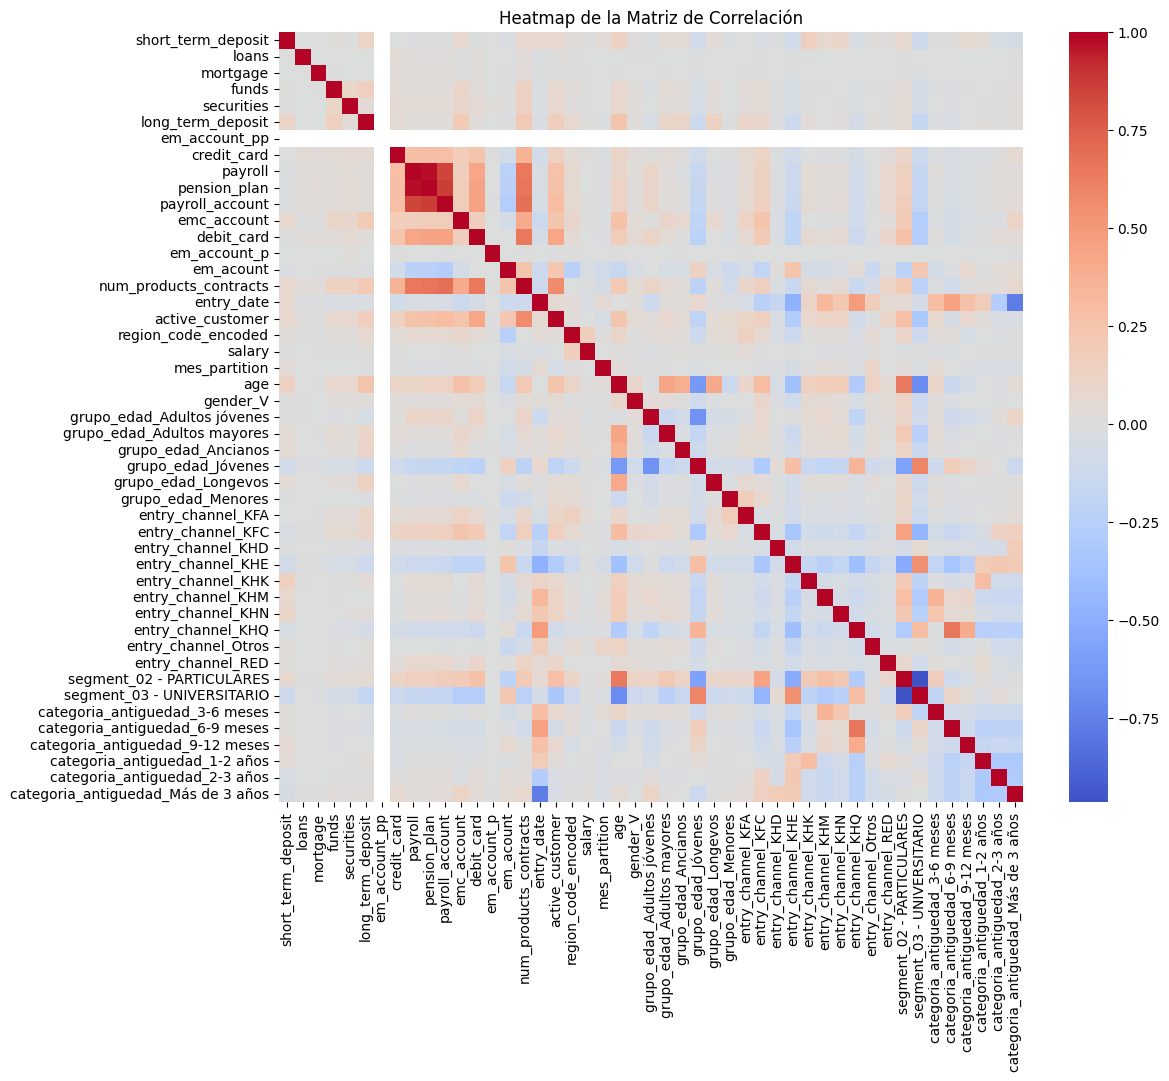

Pares de variables altamente correlacionadas:
('payroll', 'pension_plan')
('segment_02 - PARTICULARES', 'segment_03 - UNIVERSITARIO')


In [42]:
# Calcular la matriz de correlación
matriz_correlacion = df_numerico_segmetacion_1.corr()

# Visualizar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, cmap='coolwarm', center=0)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

# Identificar variables altamente correlacionadas
umbral = 0.9
correlaciones_altas = np.where(np.abs(matriz_correlacion) > umbral)
pares_correlacionados = [(matriz_correlacion.index[x], matriz_correlacion.columns[y]) for x, y in zip(*correlaciones_altas) if x != y and x < y]

print("Pares de variables altamente correlacionadas:")
for par in pares_correlacionados:
    print(par)

Analizando las variables para determinar cuál es mejor eliminar, en los dos casos, ambas variables representan a aspectos específicos de clientes. Por lo tanto aunque estén correlacionadas, se van a mantener ya que pueden ofrecer diferentes insights. Por tanto, mantenemos todas las variables.


### 3. Estandarización de las variables numéricas

In [43]:
# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the data
df_estandarizado = scaler.fit_transform(df_numerico_segmetacion_1)

# Convert the result to a DataFrame
df_estandarizado = pd.DataFrame(df_estandarizado , columns=df_numerico_segmetacion_1.columns)

# Verify the results
df_estandarizado

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,entry_date,active_customer,region_code_encoded,salary,mes_partition,age,gender_V,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_Más de 3 años
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.500,0.000,0.486,0.500,1.869,0.749,3.000,2.429,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.641,0.714,1.869,0.749,0.000,2.643,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,1.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.167,0.000,0.688,0.833,0.694,1.115,0.000,3.214,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,1.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,-0.111,1.000,0.573,0.889,1.869,0.749,0.000,2.357,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,-1.000,0.000,1.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,0.000,2.000,0.058,1.000,1.869,0.238,0.000,2.071,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.904,0.000,-0.371,0.447,0.000,1.929,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
456240,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.904,0.000,0.071,-0.045,0.000,0.357,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
456241,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.904,0.000,1.869,0.937,0.000,-0.286,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
456242,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.904,0.000,-0.372,0.447,0.000,1.286,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 2.2. Ejecución del Clustering

Para optimizar la segmentación y obtener la mejor agrupación posible de los datos, se han definido tres enfoques distintos de clustering:

1.	Clustering con el Dataset Completo: En este enfoque, se aplicará el algoritmo de clustering directamente sobre el dataset completo, utilizando todas las variables originales a partir de la estandarización. (df_estandarizado)


2.	Clustering con Reducción de Dimensionalidad mediante PCA: En el segundo enfoque, se aplicará la técnica de Análisis de Componentes Principales (PCA) para reducir la dimensionalidad del dataset. Esta reducción ayudará a identificar los componentes principales que capturan la mayor parte de la varianza de los datos originales. Posteriormente, se aplicará el algoritmo de clustering sobre el dataset reducido para evaluar si la reducción de dimensionalidad mejora la segmentación.


3.	Clustering con Ingeniería de Características: El tercer enfoque se centrará en la creación de nuevas características relevantes a partir de las variables existentes. Luego, se aplicará el algoritmo de clustering.

Cada uno de estos enfoques será evaluado en términos de calidad de la segmentación, utilizando métricas como la inercia y la puntuación de silueta, entre otras. El objetivo es identificar el enfoque que proporciona los clusters más claros, significativos y útiles para las aplicaciones comerciales del análisis.


### 1. Clustering con el Dataset Completo

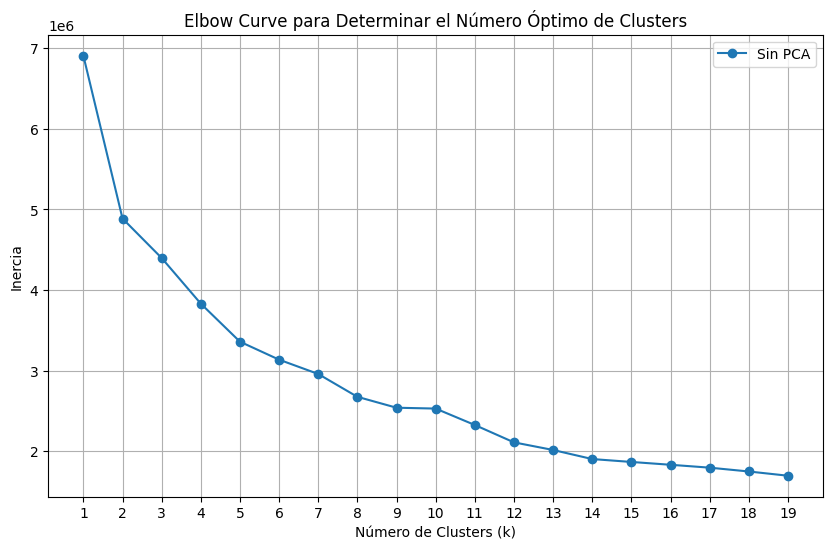

In [44]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_estandarizado)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Sin PCA')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()


•	La curva de codo muestra una fuerte disminución de la inercia a medida que el número de clusters aumenta de 2 a aproximadamente 5 o 6. Después de ese punto, la reducción de la inercia se vuelve menos pronunciada y tiende a estabilizarse a medida que el número de clusters aumenta.

•	Basado en la observación del gráfico, 5 parece ser el número óptimo de clusters. Esto significa que segmentar los datos en 5 grupos podría capturar la estructura inherente de los datos de manera eficiente, con una buena representación de la variabilidad y sin complejidad innecesaria.

### 2. Clustering con Reducción de Dimensionalidad mediante PCA

Se ejecuta este analisis a partir del df_estandarizado

Este analisis se centra en identificar la cantidad de componentes principales para retener el 95% de la varianza en el dataset df_estandarizado.

Y una vez reducido el dataset de 47 variables a 13 se le aplica el clustering.

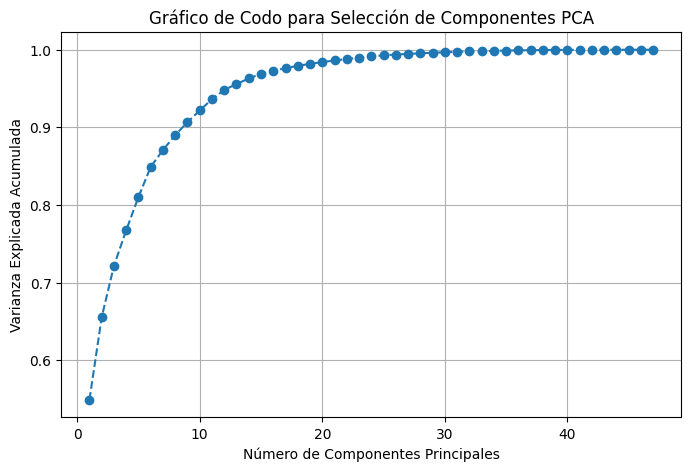

Número de componentes: 13
     PC1   PC2    PC3    PC4    PC5    PC6    PC7    PC8   PC9   PC10  PC11  \
0  0.485 1.676 -2.437 -0.513  0.702  2.475 -1.005  0.098 0.678  0.019 0.375   
1  0.488 1.217 -2.848 -0.533  0.062 -0.570 -0.806 -0.138 0.747  0.011 0.307   
2  0.787 1.823 -1.661  0.482  0.473 -0.535 -0.983  0.150 0.095 -0.038 1.399   
3  0.474 2.357 -1.201 -1.004  0.336 -0.365 -0.859 -0.113 0.830 -0.040 0.601   
4 -0.034 2.834 -0.207 -1.169 -0.031 -0.094 -0.948  0.666 0.534 -0.337 0.117   

    PC12   PC13  
0 -0.133  0.044  
1  0.145  0.147  
2  0.235  0.387  
3 -0.162 -0.017  
4 -0.311 -0.315  


In [45]:
# Aplicar PCA
pca = PCA()
pca.fit(df_estandarizado)

# Varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_
varianza_explicada_acumulada = np.cumsum(varianza_explicada)

# Plot de varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_explicada_acumulada) + 1), varianza_explicada_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Gráfico de Codo para Selección de Componentes PCA')
plt.grid(True)
plt.show()

# Selección de número de componentes que expliquen al menos el 95% de la varianza
n_componentes = np.argmax(varianza_explicada_acumulada >= 0.95) + 1
print(f"Número de componentes: {n_componentes}")

# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_componentes)
caracteristicas_reducidas = pca.fit_transform(df_estandarizado)

# Crear un DataFrame con los componentes principales
df_pca = pd.DataFrame(caracteristicas_reducidas, columns=[f'PC{i+1}' for i in range(n_componentes)])

# Mostrar los primeros registros con los componentes principales
print(df_pca.head())

El gráfico de codo para la selección de componentes principales muestra la varianza explicada acumulada por el número de componentes principales.

•	Número de Componentes Seleccionados: Se han identificado 13 componentes principales, lo cual es razonable ya que se busca retener la mayoría de la varianza (normalmente se busca retener al menos el 90-95% de la varianza). Esto significa que, aunque tu dataset original tenía 47 variables, puedes reducirlo a 13 componentes principales sin perder mucha información. Estos componentes representan combinaciones lineales de las variables originales que capturan la estructura de los datos.

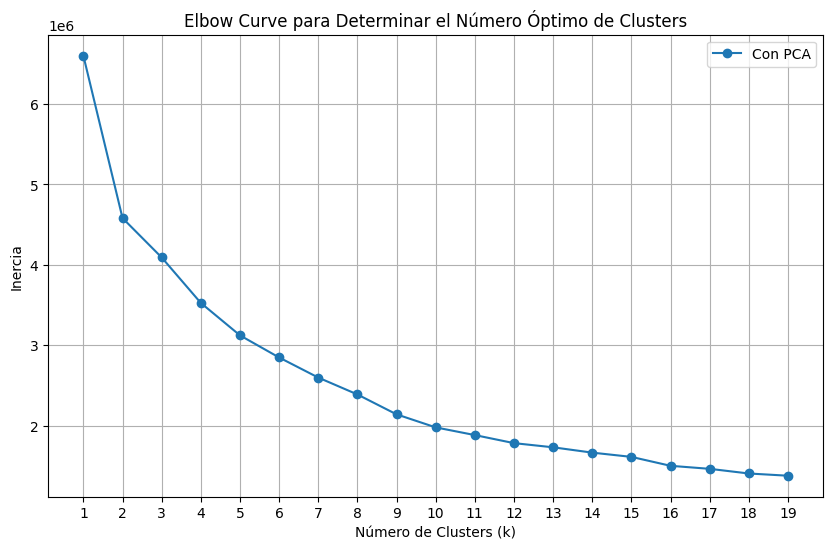

In [46]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Con PCA')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()

Aparentemente parece que presenta el mismo comportamiento que en el analisis anterior, pero se ha reducido los valores de la inercia lo cual es importante ya que implica que los cluster sean más compactos, además al parecer el cluster optimo se encuentra entre  k = 4, 5 o 6. Un analisis más profundo se realiza al final.

### 3. Clustering con Ingeniería de Características

En esta etapa se trabaja con el df_clustering con todas las variables originales, al que se le va a aplicar ingenieria de caracteristicas, para luego analizar su correlacion, estandarizar y aplicar el clustering

1. Se crean nuevas columnas agrupando los productos en tres categorias: cuentas, ahorro_inversion y financiacion.

In [47]:
# Crear nuevas columnas para las categorías
df_clustering['cuentas'] = df_clustering[['short_term_deposit', 'long_term_deposit', 'payroll_account', 
                             'em_account_pp', 'em_account_p', 'em_acount', 'emc_account']].mean(axis=1)

df_clustering['ahorro_inversion'] = df_clustering[['funds', 'securities', 'pension_plan']].mean(axis=1)

df_clustering['financiacion'] = df_clustering[['loans', 'credit_card', 'mortgage', 'debit_card']].mean(axis=1)


# Eliminar las columnas de productos
df_clustering.drop(columns=productos, inplace=True)

In [48]:
df_clustering

,num_products_contracts,entry_date,active_customer,region_code_encoded,gender,salary,mes_partition,grupo_edad,age,entry_channel,segment,categoria_antiguedad,cuentas,ahorro_inversion,financiacion
pk_cid,,,,,,,,,,,,,,,
15891,1,736903,0.500,0.199,H,"132,384.450",8,Adultos mayores,59,KAT,02 - PARTICULARES,0-3 meses,0.071,0.000,0.000
16063,0,737017,0.714,0.199,H,"132,384.450",5,Adultos mayores,62,KAT,02 - PARTICULARES,6-9 meses,0.000,0.000,0.000
16203,1,737051,0.833,0.101,V,"153,902.880",5,Ancianos,70,KAT,01 - TOP,3-6 meses,0.119,0.000,0.000
16502,2,736967,0.889,0.199,H,"132,384.450",5,Adultos mayores,58,KHN,02 - PARTICULARES,6-9 meses,0.206,0.000,0.000
17457,3,736588,1.000,0.199,H,"102,405.750",5,Adultos,54,KAT,02 - PARTICULARES,1-2 años,0.277,0.000,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,0.012,V,"114,633.765",5,Adultos,52,Otros,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000
1553686,0,737210,0.000,0.049,H,"85,787.220",5,Adultos jóvenes,30,Otros,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000
1553687,0,737210,0.000,0.199,V,"143,419.770",5,Jóvenes,21,Otros,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000


2. Se categorizan los canales de entrada entre principales y secundarios.

In [49]:

# Lista de canales considerados como principales
canales_principales = ['KHE', 'KHQ', 'KFC']

# Crear una nueva columna para categorizar los canales
df_clustering['entry_channel_group'] = df_clustering['entry_channel'].apply(lambda x: 'Canal Principal' if x in canales_principales else 'Canal Secundario')

# Eliminar la columna original
df_clustering.drop(columns=['entry_channel'], inplace=True)


3. Se toma la decision de eliminar las siguientes variables para evitar riesgos de redundancia:


In [50]:
df_clustering.drop(columns=['segment'], inplace=True)
df_clustering.drop(columns=['grupo_edad'], inplace=True)
df_clustering.drop(columns=['gender'], inplace=True)
df_clustering.drop(columns=['region_code_encoded'], inplace=True)  

4. Se codifica la variable categoria_antiguedad segun la frecuencia que se repite cada categoria

In [51]:
# Paso 1: Calcular la frecuencia de cada categoria_antiguedad
frecuencias_antigueda = df_clustering['categoria_antiguedad'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas

# Paso 2: Mapear las frecuencias a la columna de categoria_antiguedad
df_full_clean['categoria_antiguedad_encoded'] = df_clustering['categoria_antiguedad'].map(frecuencias_antigueda)

# se agrupa por pk_cid y se toma el último valor de la columna categoria_antiguedad_encoded
df_antiguedad_frecuency = df_full_clean.groupby("pk_cid")["categoria_antiguedad_encoded"].last()

# eliminar la columna categoria_antiguedad
df_clustering.drop(columns=['categoria_antiguedad'], inplace=True)

In [52]:
df_clustering

,num_products_contracts,entry_date,active_customer,salary,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group
pk_cid,,,,,,,,,,
15891,1,736903,0.500,"132,384.450",8,59,0.071,0.000,0.000,Canal Secundario
16063,0,737017,0.714,"132,384.450",5,62,0.000,0.000,0.000,Canal Secundario
16203,1,737051,0.833,"153,902.880",5,70,0.119,0.000,0.000,Canal Secundario
16502,2,736967,0.889,"132,384.450",5,58,0.206,0.000,0.000,Canal Secundario
17457,3,736588,1.000,"102,405.750",5,54,0.277,0.000,0.074,Canal Secundario
...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,"114,633.765",5,52,0.000,0.000,0.000,Canal Secundario
1553686,0,737210,0.000,"85,787.220",5,30,0.000,0.000,0.000,Canal Secundario
1553687,0,737210,0.000,"143,419.770",5,21,0.000,0.000,0.000,Canal Secundario


5. Se clasifican los salarios en bajos, medios y altos.

In [53]:
# Supongamos que tienes un DataFrame 'df' con una columna 'salary' que representa los salarios
# Asegúrate de que los valores de 'salary' estén en formato numérico
df_clustering['salary'] = df_clustering['salary'].replace(',', '', regex=True).astype(float)

# Calcular los percentiles para definir los umbrales
low_threshold = df_clustering['salary'].quantile(0.33)
high_threshold = df_clustering['salary'].quantile(0.66)

# Definir una función para clasificar los salarios
def categorize_salary(salary):
    if salary <= low_threshold:
        return 'Ingreso Bajo'
    elif salary <= high_threshold:
        return 'Ingreso Medio'
    else:
        return 'Ingreso Alto'

# Aplicar la función a la columna 'salary'
df_clustering['salary_category'] = df_clustering['salary'].apply(categorize_salary)

# Mostrar las primeras filas del DataFrame con la nueva columna
#print(df[['salary', 'salary_category']].head())
df_clustering.drop(columns=['salary'], inplace=True)
df_clustering["salary_category"] = df_clustering["salary_category"].astype("category")

df_clustering["entry_channel_group"] = df_clustering["entry_channel_group"].astype("category")


In [54]:
# pasamos de tener 27 columnas en el df_clustering a 10 columnas
df_clustering.columns

Index(['num_products_contracts', 'entry_date', 'active_customer',
       'mes_partition', 'age', 'cuentas', 'ahorro_inversion', 'financiacion',
       'entry_channel_group', 'salary_category'],
      dtype='object')

In [55]:
# df para clustering 3
df_clustering_segmentacion_3 = df_clustering

6. Se llevan las columnas categoricas de df_clustering_segmentacion_3 a numericas para el analisis de correlacion

In [56]:
# Identificar las columnas categóricas
columnas_categoricas = df_clustering_segmentacion_3.dtypes.loc[df_clustering_segmentacion_3.dtypes == "category"].index.tolist()

# Aplicar one-hot encoding usando pandas.get_dummies
df_seg_3 = pd.get_dummies(df_clustering_segmentacion_3, columns=columnas_categoricas, dtype=int, drop_first=True)

# Verificar el resultado
df_seg_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,1,736903,0.500,8,59,0.071,0.000,0.000,1,0,0
16063,0,737017,0.714,5,62,0.000,0.000,0.000,1,0,0
16203,1,737051,0.833,5,70,0.119,0.000,0.000,1,0,0
16502,2,736967,0.889,5,58,0.206,0.000,0.000,1,0,0
17457,3,736588,1.000,5,54,0.277,0.000,0.074,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,5,52,0.000,0.000,0.000,1,0,0
1553686,0,737210,0.000,5,30,0.000,0.000,0.000,1,0,1
1553687,0,737210,0.000,5,21,0.000,0.000,0.000,1,0,0


7. Analisis de correlacion

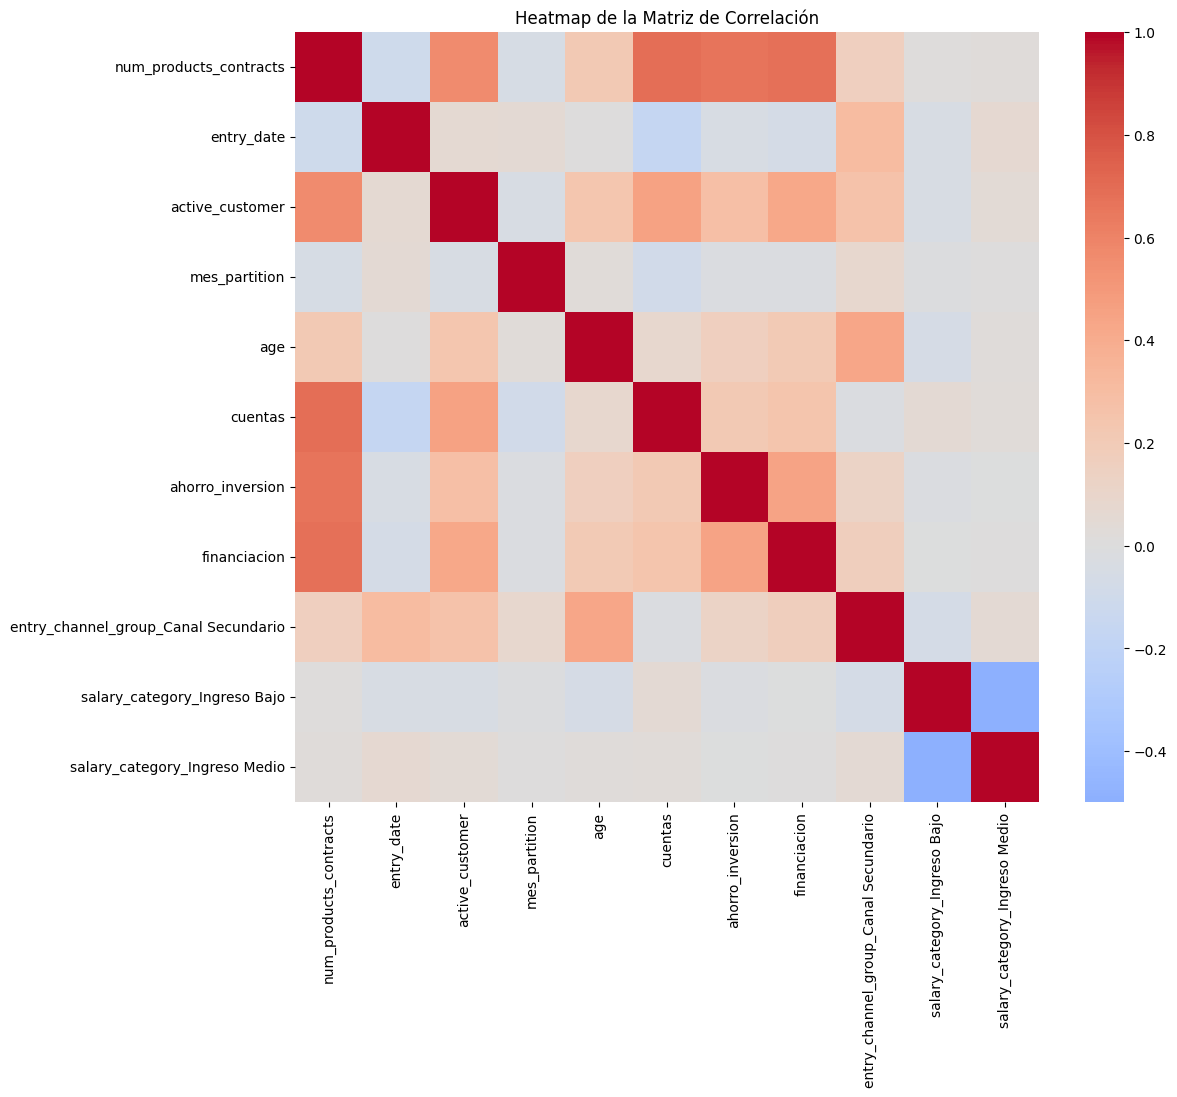

Pares de variables altamente correlacionadas:


In [57]:
# Calcular la matriz de correlación
matriz_correlacion = df_seg_3.corr()

# Visualizar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, cmap='coolwarm', center=0)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

# Identificar variables altamente correlacionadas
umbral = 0.9
correlaciones_altas = np.where(np.abs(matriz_correlacion) > umbral)
pares_correlacionados = [(matriz_correlacion.index[x], matriz_correlacion.columns[y]) for x, y in zip(*correlaciones_altas) if x != y and x < y]

print("Pares de variables altamente correlacionadas:")
for par in pares_correlacionados:
    print(par)

No existen variables altamente correlacionadas

In [58]:
df_seg_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,1,736903,0.500,8,59,0.071,0.000,0.000,1,0,0
16063,0,737017,0.714,5,62,0.000,0.000,0.000,1,0,0
16203,1,737051,0.833,5,70,0.119,0.000,0.000,1,0,0
16502,2,736967,0.889,5,58,0.206,0.000,0.000,1,0,0
17457,3,736588,1.000,5,54,0.277,0.000,0.074,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,5,52,0.000,0.000,0.000,1,0,0
1553686,0,737210,0.000,5,30,0.000,0.000,0.000,1,0,1
1553687,0,737210,0.000,5,21,0.000,0.000,0.000,1,0,0


8. Estandarizacion de las variables

In [59]:
# Separar pk_cid
pk_cid = df_seg_3.index  # O también puedes usar df_seg_3['pk_cid'] si pk_cid no es el índice

# Inicializar el scaler
scaler = RobustScaler()

# Fit y transformar los datos numéricos (sin pk_cid)
df_numerico_estandarizado_3 = scaler.fit_transform(df_seg_3)

# Convertir el resultado de nuevo en un DataFrame
df_numerico_estandarizado_3 = pd.DataFrame(df_numerico_estandarizado_3, columns=df_seg_3.columns)

# Añadir nuevamente el pk_cid como una columna (o volver a ponerlo como índice)
df_numerico_estandarizado_3['pk_cid'] = pk_cid

# Verificar los resultados
df_numerico_estandarizado_3 = df_numerico_estandarizado_3.set_index('pk_cid')  # Si pk_cid era el índice original

In [60]:
df_numerico_estandarizado_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,0.000,0.486,0.500,3.000,2.429,-0.773,0.000,0.000,1.000,0.000,0.000
16063,-1.000,0.641,0.714,0.000,2.643,-1.545,0.000,0.000,1.000,0.000,0.000
16203,0.000,0.688,0.833,0.000,3.214,-0.258,0.000,0.000,1.000,0.000,0.000
16502,1.000,0.573,0.889,0.000,2.357,0.687,0.000,0.000,1.000,0.000,0.000
17457,2.000,0.058,1.000,0.000,2.071,1.455,0.000,0.074,1.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...
1553685,-1.000,0.904,0.000,0.000,1.929,-1.545,0.000,0.000,1.000,0.000,0.000
1553686,-1.000,0.904,0.000,0.000,0.357,-1.545,0.000,0.000,1.000,0.000,1.000
1553687,-1.000,0.904,0.000,0.000,-0.286,-1.545,0.000,0.000,1.000,0.000,0.000


### 4. Analisis Clustering

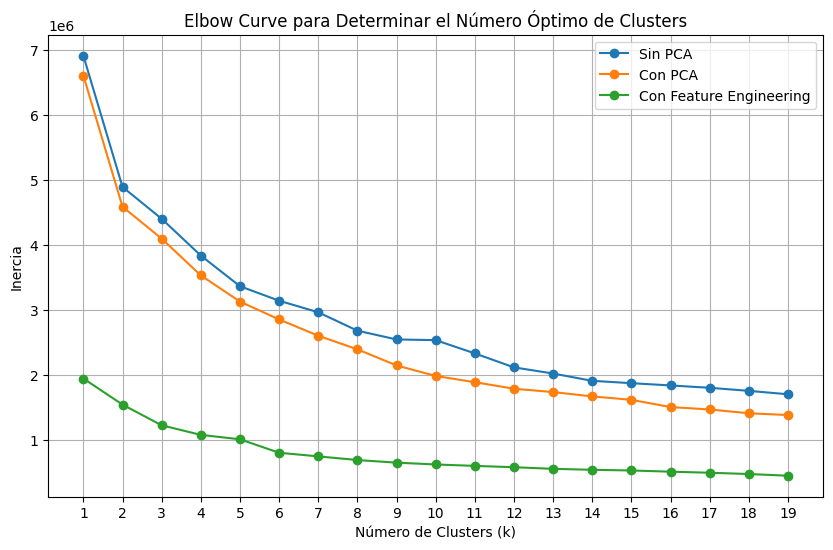

In [61]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias_original = []
inercias_pca = []
inercias = []

# Aplicar K-means para cada valor de k y calcular la inercia para el dataset original
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_estandarizado)
    inercias_original.append(kmeans.inertia_)

# Aplicar K-means para cada valor de k y calcular la inercia para el dataset con PCA
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inercias_pca.append(kmeans.inertia_)

# Aplicar K-means para cada valor de k y calcular la inercia para el dataset con el Feature Engineering
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerico_estandarizado_3)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias_original, marker='o', linestyle='-', label='Sin PCA')
plt.plot(rango_k, inercias_pca, marker='o', linestyle='-', label='Con PCA')
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Con Feature Engineering')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()

Como no se observa bien la curva del codo para Feature Engineering, abajo se vuelve a mostrar

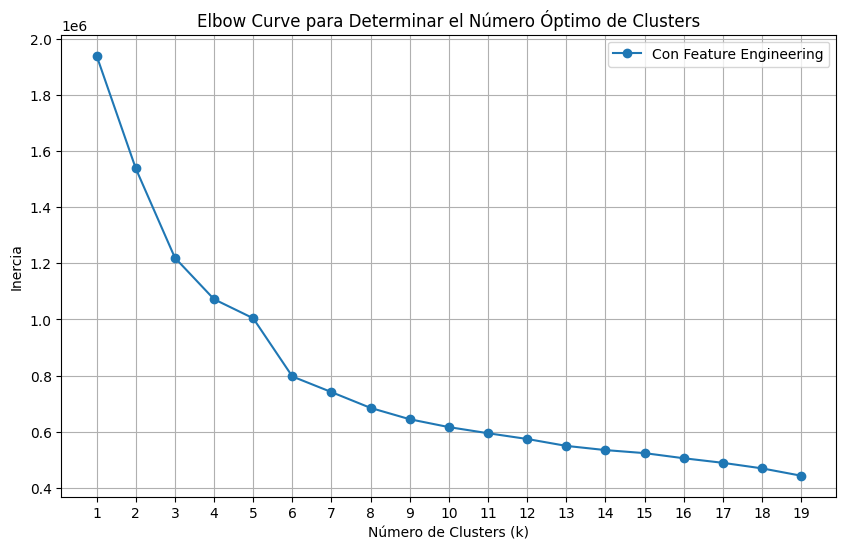

In [62]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []
    
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerico_estandarizado_3)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Con Feature Engineering')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()

En el gráfico, el codo parece situarse entre 5, 6 o 7 clusters. Esto sugiere que agregar más clusters no proporciona una mejora significativa en la reducción de inercia, lo que implica que los clusters adicionales no están capturando mucha información adicional.

Resumiendo:


•	Feature Engineering: Este enfoque muestra la inercia más baja, lo que indica que las nuevas variables son más efectivas para capturar las diferencias entre los datos. La reducción de inercia es significativa incluso con un pequeño número de clusters, lo cual es una señal positiva de un buen diseño de las características.

•	PCA: Aunque mejora la segmentación respecto a no usar ninguna reducción de dimensionalidad, no es tan efectiva como la ingeniería de características para reducir la inercia. Sin embargo, aún presenta una mejora significativa en comparación con el dataset original.

•	Sin PCA: Este es el enfoque más básico y muestra la mayor inercia a medida que se agregan clusters, indicando que las variables originales sin transformación no son tan efectivas para segmentar los datos de manera óptima.

## 2.3. Interpretación del Clustering

### 1. Selección del cluster adecuado

In [63]:
df_numerico_estandarizado_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,0.000,0.486,0.500,3.000,2.429,-0.773,0.000,0.000,1.000,0.000,0.000
16063,-1.000,0.641,0.714,0.000,2.643,-1.545,0.000,0.000,1.000,0.000,0.000
16203,0.000,0.688,0.833,0.000,3.214,-0.258,0.000,0.000,1.000,0.000,0.000
16502,1.000,0.573,0.889,0.000,2.357,0.687,0.000,0.000,1.000,0.000,0.000
17457,2.000,0.058,1.000,0.000,2.071,1.455,0.000,0.074,1.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...
1553685,-1.000,0.904,0.000,0.000,1.929,-1.545,0.000,0.000,1.000,0.000,0.000
1553686,-1.000,0.904,0.000,0.000,0.357,-1.545,0.000,0.000,1.000,0.000,1.000
1553687,-1.000,0.904,0.000,0.000,-0.286,-1.545,0.000,0.000,1.000,0.000,0.000


In [64]:
# Aplicar K-Means con 4, 5 y 6 clusters para ver la distribución de los datos
kmeans_final_4 = KMeans(n_clusters=4, random_state=42)
kmeans_final_5 = KMeans(n_clusters=5, random_state=42)
kmeans_final_6 = KMeans(n_clusters=6, random_state=42)

df_numerico_estandarizado_3['cluster_4'] = kmeans_final_4.fit_predict(df_numerico_estandarizado_3)
df_numerico_estandarizado_3['cluster_5'] = kmeans_final_5.fit_predict(df_numerico_estandarizado_3)
df_numerico_estandarizado_3['cluster_6'] = kmeans_final_6.fit_predict(df_numerico_estandarizado_3)

print(df_numerico_estandarizado_3['cluster_4'].value_counts())
print(df_numerico_estandarizado_3['cluster_5'].value_counts())
print(df_numerico_estandarizado_3['cluster_6'].value_counts())


cluster_4
3    242079
1    107071
0     70878
2     36216
Name: count, dtype: int64
cluster_5
0    241365
1    101683
4     70079
2     36084
3      7033
Name: count, dtype: int64
cluster_6
0    121000
3    120365
2    101683
5     70079
4     36084
1      7033
Name: count, dtype: int64


Como se puede observar en la gráfica del codo, el número óptimo de clusters se encuentra entre 5, 6 o 7. A pesar de que la Directora General, Carol, había propuesto segmentar la base de clientes en 7 u 8 grupos de clientes similares, hemos decidido trabajar con un máximo de 6 clusters.

Esta decisión se basa en el análisis de la inercia, que muestra que añadir más de 6 clusters no proporciona una mejora significativa en la reducción de la inercia. Esto sugiere que los clusters adicionales no capturan mucha información adicional, lo cual no justifica la complejidad añadida de más clusters. Además, la distribución de clientes en los clusters cuando se utilizan 6 grupos es bastante equilibrada y manejable, lo que facilita tanto la interpretación como la implementación de estrategias.


Optar por 6 clusters nos permite un buen equilibrio entre detalle y manejabilidad, asegurando que cada grupo es lo suficientemente grande como para proporcionar insights significativos, sin ser tan grande como para perder especificidad o ser difícil de gestionar.

Con esta tabla resumen, se obtienen las medias de las características por cluster, la distribución y el peso relativo de cada cluster en términos de volumen de productos contratados y la cantidad de clientes.

In [65]:
# Lista de columnas excluyendo las de los clusters específicos
cols = list(df_numerico_estandarizado_3.columns)
cols.remove('cluster_6') 
cols.remove("cluster_5")
cols.remove("cluster_4")

# Calcular las medias para cada cluster
pt = pd.pivot_table(df_numerico_estandarizado_3, index='cluster_6', values=cols, aggfunc='mean')

# Calcular la cantidad de elementos en cada cluster
add = pd.pivot_table(df_numerico_estandarizado_3, index='cluster_6', values='num_products_contracts', aggfunc='count')
pt['count'] = add

# Añadir 'count' a la lista de columnas para la visualización final
cols.append('count')

# Mostrar la tabla con estilos y gradientes de color
pt[cols].style.background_gradient(cmap='coolwarm')




,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio,count
cluster_6,,,,,,,,,,,,
0,0.092669,-0.682608,0.284318,-0.004231,0.062017,-0.006929,0.000334,0.010066,0.079157,0.378909,0.315628,121000
1,-0.515143,0.306371,0.165963,5.550690,0.728718,-1.131848,0.002862,0.007962,0.716195,0.258780,0.359733,7033
2,-0.960515,0.008819,0.036818,-0.050274,0.277696,-1.535168,0.000078,0.000468,0.272927,0.273182,0.294622,101683
3,0.080381,0.328310,0.405837,-0.010684,-0.123099,-0.041521,0.000278,0.008406,0.116039,0.381672,0.359041,120365
4,2.870829,-0.236580,0.945479,-0.008646,0.886058,0.515539,0.146619,0.148449,0.491935,0.311024,0.328982,36084
5,0.401204,0.098681,0.754279,-0.037971,1.758991,-0.057222,0.005801,0.041507,0.707944,0.256910,0.393427,70079


Desnormalización de las variables para una mejor interpretación.

In [66]:
df_desnorm = df_seg_3.copy()
df_desnorm["cluster_6"] = df_numerico_estandarizado_3["cluster_6"]
# llevando la columna entry_date a su formato original
df_desnorm["entry_date"] = df_desnorm["entry_date"].apply(lambda x: datetime.fromordinal(x))
df_desnorm.groupby("cluster_6").mean()

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
cluster_6,,,,,,,,,,,
0,1.093,2016-03-19 14:24:29.276033024,0.284,4.996,25.868,0.142,0.000,0.010,0.079,0.379,0.316
1,0.485,2018-03-17 11:44:07.916962816,0.166,10.551,35.202,0.038,0.003,0.008,0.716,0.259,0.360
2,0.039,2017-08-10 11:46:16.216280064,0.037,4.950,28.888,0.001,0.000,0.000,0.273,0.273,0.295
3,1.080,2018-04-02 15:15:45.992605696,0.406,4.989,23.277,0.139,0.000,0.008,0.116,0.382,0.359
4,3.871,2017-02-10 21:03:05.567010304,0.945,4.991,37.405,0.191,0.147,0.148,0.492,0.311,0.329
5,1.401,2017-10-15 15:05:58.309907456,0.754,4.962,49.626,0.138,0.006,0.042,0.708,0.257,0.393


- Clúster 4 es sin duda el grupo de mayor valor, con clientes muy comprometidos y una alta contratación de productos financieros. Representa una gran oportunidad de negocio para aumentar la lealtad y seguir ofreciéndoles más productos.

- Clúster 5 también tiene un buen potencial, aunque está compuesto por clientes más mayores. Aún así, su alta actividad y moderada participación en productos financieros lo hacen un grupo importante para mantener relaciones a largo plazo.

- Clústeres 0 y 3 representan a clientes jóvenes, con potencial de crecimiento. Aunque no son tan valiosos ahora, con las estrategias adecuadas, estos clientes podrían escalar en valor en el futuro.

- Clústeres 1 y 2 son de bajo compromiso. Los clientes en estos grupos parecen tener poco interés en productos financieros, ya sea por falta de interés o porque no ven utilidad en los servicios ofrecidos. Este tipo de clústeres requiere estrategias de reactivación o, en algunos casos, simplemente podrían representar clientes que no son rentables para la entidad.

En resumen, el análisis de estos clústeres permite identificar grupos de alto valor (clúster 4 y, en menor medida, clúster 5), grupos con potencial de crecimiento (clústeres 0 y 3), y grupos en riesgo de abandono o de bajo valor (clústeres 1 y 2). 

### 2. Análisis de la Importancia de las Características.


- Se identifican las características más importantes para diferenciar mejor entre los clusters, utilizando un modelo de Random Forest básico.

In [ ]:
df_numerico_estandarizado_3.columns

Index(['num_products_contracts', 'entry_date', 'active_customer',
       'mes_partition', 'age', 'cuentas', 'ahorro_inversion', 'financiacion',
       'entry_channel_group_Canal Secundario', 'salary_category_Ingreso Bajo',
       'salary_category_Ingreso Medio', 'cluster_4', 'cluster_5', 'cluster_6'],
      dtype='object')

<Axes: title={'center': 'Importancia de las Características para la Segmentación'}>

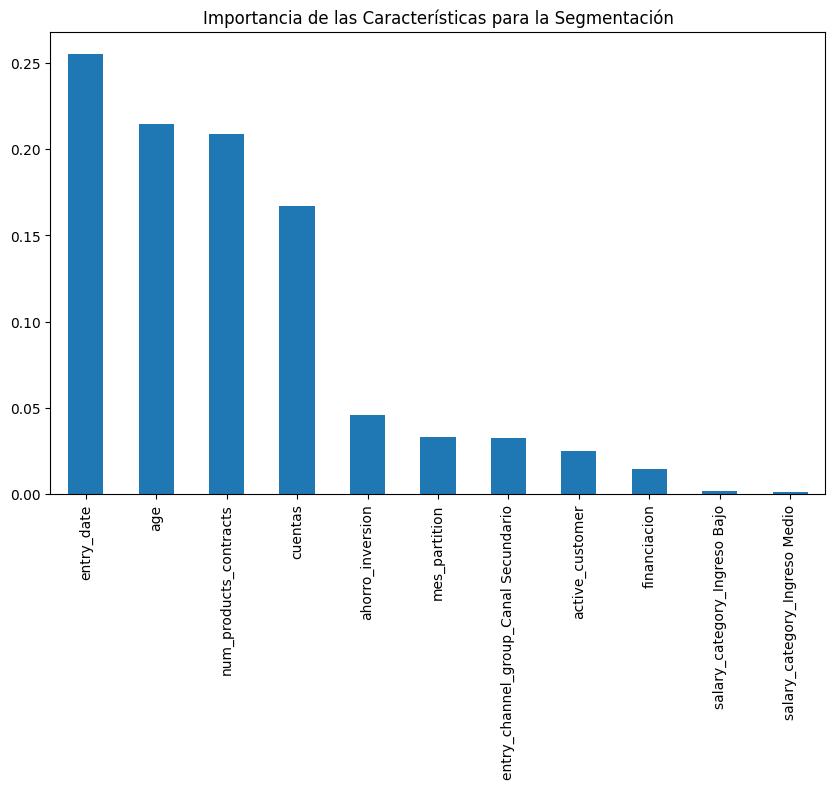

In [ ]:
from sklearn.ensemble import RandomForestClassifier

df_numerico_estandarizado_3.drop(columns=["cluster_4","cluster_5"], inplace=True)
cols = ['num_products_contracts', 'entry_date', 'active_customer',"age",
       'mes_partition', 'cuentas', 'ahorro_inversion', 'financiacion',
       'entry_channel_group_Canal Secundario', 'salary_category_Ingreso Bajo',
       'salary_category_Ingreso Medio']
# Asumiendo que 'cluster_6' es la variable objetivo
X = df_numerico_estandarizado_3[cols]  # Características sin la columna de cluster
y = df_numerico_estandarizado_3['cluster_6']  # Variable objetivo

# Entrenar un modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Obtener la importancia de las características
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), title='Importancia de las Características para la Segmentación')


- entry_date y age son las características más importantes para la segmentación. Esto sugiere que la fecha de ingreso al sistema y la edad de los usuarios son variables clave para determinar cómo se agrupan los individuos. El hecho de que la fecha de ingreso sea la característica más importante sugiere que los usuarios se agrupan en función de cuándo se unieron al sistema, lo que podría reflejar tendencias temporales en su comportamiento.

- num_products_contracts (número de productos contratados) también tiene un peso importante. Los clientes que tienen más productos tienden a agruparse de manera distinta de los que tienen menos.

- Otras variables como cuentas, ahorro_inversion y active_customer también tienen un impacto considerable, aunque menos que las tres anteriores.

- Las variables relacionadas con la categoría salarial (salary_category_Ingreso Bajo, salary_category_Ingreso Medio) tienen una importancia mucho menor, lo que indica que el nivel de ingresos no es un diferenciador fuerte entre los clústeres.


### 3. Definición de los clusters
Teniendo en cuenta el análisis anterior y que el objetivo de la segmentación es conocer mejor la base de clientes para orientar la actividad comercial de la empresa, según nos propone la Directora General Carol, quedan definidos los clusters de la siguiente forma: 


Clúster 0: “Jóvenes de Baja Actividad”

(Clientes jóvenes que ingresaron hace varios años pero muestran baja actividad y contratación de productos. Tienen un compromiso reducido y pueden estar en fase de crecimiento o simplemente no requieren productos financieros complejos.)

- Edad media: 25.87 años (clientes jóvenes).
- Fecha de ingreso: marzo de 2016 (clientes antiguos en el sistema).
- Productos contratados: 1.093 productos (número de productos por cliente es bajo).
- Clientes activos: 28.4% son clientes activos.
- Financiación: Casi nula (0.01%).
- Canal secundario: 7.9% ingresaron por el canal secundario.
- Ingreso bajo/medio: 37.9% de clientes de ingreso bajo y 31.6% de ingreso medio.

Este grupo está compuesto por clientes jóvenes, que ingresaron hace varios años al sistema. Aunque no son clientes muy activos, han contratado algunos productos. Son clientes de bajo valor, con poca o nula participación en productos de financiación y un compromiso bajo (28.4% de activos). Su perfil indica que podrían estar en fase de crecimiento o simplemente tener una baja necesidad de productos financieros complejos.

Estrategias:

1.	Programa de Recompensas por Uso Activo:
- Implementar un programa de recompensas que ofrezca puntos o descuentos a los clientes cada vez que realicen transacciones, utilicen sus tarjetas de crédito, o contraten nuevos productos. Esto incentiva un mayor uso de los servicios y aumenta el compromiso con la empresa.
---
Clúster 1: “Nuevos Clientes de Bajo Compromiso”

(Clientes de mediana edad que ingresaron recientemente a través del canal secundario. Presentan una baja contratación de productos y poca actividad, lo que indica un compromiso limitado con la entidad.)

- Edad media: 35.2 años.
- Fecha de ingreso: marzo de 2018 (clientes relativamente nuevos).
- Productos contratados: 0.485 productos (bastante bajo).
- Clientes activos: 16.6% de clientes activos.
- Financiación: Muy baja (0.8%).
- Canal secundario: 71.6% ingresaron por el canal secundario.
- Ingreso bajo/medio: 25.9% de ingreso bajo y 36% de ingreso medio.

Este clúster agrupa a clientes en su mediana edad que ingresaron recientemente al sistema. Tienen una baja contratación de productos y una participación activa muy reducida. El hecho de que una gran parte de estos clientes hayan ingresado a través de un canal secundario (71.6%) podría indicar que fueron captados por alguna estrategia de marketing externa o menos directa. Esto sugiere que quizás no están suficientemente comprometidos con la entidad, ya que su número de productos es bajo y su actividad también.

Estrategias:

- Campañas de Enganche Personalizadas: Enviar ofertas y promociones personalizadas para incentivar la contratación de nuevos productos.

- Mejora de la Experiencia Digital: Optimizar canales digitales para facilitar el acceso y uso de servicios.




---

Clúster 2: “Jóvenes Inactivos Sin Productos”

(El grupo de menor valor. Son clientes jóvenes con casi ningún producto contratado y mínima actividad. Están en riesgo de abandono o no encuentran utilidad en los servicios ofrecidos.)

- Edad media: 28.88 años (jóvenes).
- Fecha de ingreso: agosto de 2017.
- Productos contratados: 0.039 productos (casi inexistente).
- Clientes activos: 3.7% de clientes activos.
- Financiación: Nula.
- Canal secundario: 27.3% ingresaron por el canal secundario.
- Ingreso bajo/medio: 27.3% de ingreso bajo y 29.5% de ingreso medio.

Este clúster es probablemente el grupo de menor valor. Los clientes son jóvenes, tienen muy pocos productos contratados y prácticamente no son clientes activos. Aunque una parte de ellos ingresó por el canal secundario, la mayoría probablemente ingresó de forma orgánica, pero no se han comprometido con la entidad. Estos podrían ser clientes en riesgo de abandono, o simplemente clientes que no encuentran utilidad en los productos ofrecidos.

Estrategias:

- Reactivación de Clientes Inactivos: Ofrecer incentivos para volver a utilizar los servicios.
  
- Encuestas de Satisfacción: Identificar barreras y mejorar la oferta de valor.

---

Clúster 3: “Jóvenes Activos en Crecimiento”

(El grupo más joven y con alta actividad. Aunque tienen pocos productos contratados, su alto nivel de participación indica potencial para crecer dentro del sistema financiero. Son ideales para estrategias de retención y desarrollo.)

- Edad media: 23.27 años (el grupo más joven).
- Fecha de ingreso: abril de 2018 (clientes nuevos).
- Productos contratados: 1.08 productos.
- Clientes activos: 40.6% (alta participación).
- Financiación: Baja (0.8%).
- Canal secundario: 11.6%.
- Ingreso bajo/medio: 38.2% de ingreso bajo y 35.9% de ingreso medio.

Este clúster representa a clientes muy jóvenes, que ingresaron al sistema hace poco (2018) pero tienen un alto nivel de actividad (40.6% de clientes activos). Aunque no tienen muchos productos contratados, su participación indica que podrían estar en una fase de exploración o crecimiento dentro del sistema financiero. Tienen un bajo nivel de financiación, lo que es común entre clientes más jóvenes, pero muestran un compromiso que los hace interesantes para estrategias de retención y crecimiento.

Estrategias:

- Programas Educativos Financieros: Ofrecer talleres y recursos para educar sobre productos financieros.
  
- Estrategia 2: Promociones para Jóvenes: Crear ofertas especiales que se adapten a sus necesidades.

---

Clúster 4: “Clientes Premium Altamente Comprometidos”

(Clientes de gran valor y alto compromiso. Tienen el mayor número de productos contratados y utilizan servicios financieros complejos. Son cruciales para la entidad y representan una oportunidad para fomentar la lealtad a largo plazo.)

- Edad media: 37.41 años.
- Fecha de ingreso: febrero de 2017.
- Productos contratados: 3.871 productos (el número más alto de productos).
- Clientes activos: 94.5% (el más alto de todos).
- Financiación: 14.7% (uso elevado de productos de financiación).
- Canal secundario: 49.2% (alto).
- Ingreso bajo/medio: 31.1% de ingreso bajo y 32.9% de ingreso medio.

Este clúster está compuesto por clientes de gran valor. Son clientes relativamente mayores, que tienen el mayor número de productos contratados (casi 4 por cliente) y el mayor porcentaje de clientes activos (94.5%). Estos son clientes muy comprometidos, utilizan productos financieros complejos como la financiación (14.7%), y son cruciales para la entidad. Una buena parte de ellos ingresó por el canal secundario, lo que indica que quizás fueron captados por campañas de marketing o ventas específicas. Este grupo representa una gran oportunidad para mantener el valor y fomentar su lealtad a largo plazo.

Estrategias:

- Programas de Fidelización Exclusivos: Ofrecer beneficios exclusivos para mantener su lealtad.

- Servicios Personalizados de Asesoría: Proporcionar asesoría financiera personalizada.

---

Clúster 5: “Seniors Comprometidos con Potencial”

(El grupo de mayor edad con alta actividad y moderada contratación de productos. Aunque no son tan valiosos como el clúster 4, tienen potencial para adoptar productos financieros más complejos y son importantes para estrategias de fidelización.)

- Edad media: 49.63 años (el grupo de mayor edad).
- Fecha de ingreso: octubre de 2017.
- Productos contratados: 1.401 productos.
- Clientes activos: 75.4%.
- Financiación: 4.2%.
- Canal secundario: 70.8% (similar al clúster 1).
- Ingreso bajo/medio: 25.7% de ingreso bajo y 39.3% de ingreso medio.

Este clúster agrupa a los clientes más mayores, con una edad promedio de casi 50 años. Tienen un número moderado de productos contratados (1.4 productos) y una alta tasa de actividad (75.4%). Si bien no son tan activos o valiosos como el clúster 4, siguen siendo importantes. Tienen algo de participación en productos de financiación (4.2%), lo que los hace potenciales usuarios de productos financieros más complejos a medida que su relación con la entidad avanza. Son en su mayoría clientes de ingresos medios, lo que los hace valiosos para estrategias de fidelización a largo plazo.

Estrategias: 

- Productos de Inversión Adaptados: Ofrecer productos financieros más complejos adaptados a su perfil.

- Eventos y Seminarios: Organizar eventos que fortalezcan la relación con la entidad.

---

### 4. Tabla resumen

In [22]:
import pandas as pd

# Datos de la primera tabla
data1 = {
    'Cluster': [0, 1, 2, 3, 4, 5],
    'Nombre': [
        "0_Jóvenes de Baja Actividad",
        "1_Nuevos Clientes de Bajo Compromiso",
        "2_Jóvenes Inactivos Sin Productos",
        "3_Jóvenes Activos en Crecimiento",
        "4_Clientes Premium Altamente Comprometidos",
        "5_Seniors Comprometidos con Potencial"
        
    ],
    'Número de Productos Contratados': ['Moderado', 'Bajo', 'Muy Bajo', 'Moderado', 'Alto', 'Moderado'],
    'Actividad del Cliente': ['Media Baja', 'Baja', 'Muy Baja', 'Media', 'Alta', 'Media Alta'],
    'Ingreso': ['Ingreso Bajo/Medio', 'Ingreso Medio Alto', 'Ingreso Medio Bajo', 'Ingreso Medio', 'Mixto/Medio Alto', 'Medio Alto'],
    'Canal de Entrada': [
        'Muy Bajo uso de secundarios',
        'Alto uso de secundarios',
        'Bajo uso de secundarios',
        'Bajo uso en secundarios',
        'Medio uso en secundarios',
        'Alta uso en secundarios'
    ],
    'Edad': ['Jóvenes', 'Mediana Edad', 'Jóvenes', 'Jóvenes', 'Mediana Edad', 'Mayores'],
    'Uso de Cuentas, Ahorro e Inversión': [
        'Bajo', 'Bajo', 'Muy Bajo', 'Medio Bajo', 'Alto', 'Moderado'
    ],
    'Fecha de Ingreso': [
        'Marzo 2016', 'Marzo 2018', 'Agosto 2017',
        'Abril 2018', 'Febrero 2017', 'Octubre 2017'],
    
    "Antiguedad": ["Casi 3 años", "Un año", "Casi de 2 años", "Un año", "Más de 2 años", "Casi 2 años"],
    'Descripción Breve':  [
        # Clúster 0
        'Jóvenes con baja actividad y pocos productos contratados.',
        # Clúster 1
        'Clientes recientes de mediana edad con bajo compromiso y actividad.',
        # Clúster 2
        'Jóvenes inactivos sin productos, en riesgo de abandono.',
        # Clúster 3
        'Jóvenes muy activos con potencial de crecimiento financiero.',
        # Clúster 4
        'Clientes altamente comprometidos con múltiples productos y servicios complejos.',
        # Clúster 5
        'Clientes mayores activos con potencial para productos financieros más complejos.'
    ],
    'Estrategias Clave': [
        # Clúster 0
        '- Programa de recompensas por uso activo para incentivar actividad.',
        # Clúster 1
        '- Ofertas personalizadas para aumentar contratación.\n- Mejora de canales digitales.',
        # Clúster 2
        '- Reactivación con incentivos.\n- Encuestas para identificar barreras.',
        # Clúster 3
        '- Educación financiera.\n- Promociones adaptadas a jóvenes.',
        # Clúster 4
        '- Programas de fidelización exclusivos.\n- Asesoría financiera personalizada.',
        # Clúster 5
        '- Ofrecer productos financieros más complejos.\n- Eventos para fortalecer la relación.'
    ]
}

# Datos de la segunda tabla
data2 = {
    'Cluster': [0, 1, 2, 3, 4, 5],
    'Número Medio de Productos': [1.093, 0.485, 0.039, 1.080, 3.871, 1.401],
    'Clientes Activos (%)': [28.4, 16.6, 3.7, 40.6, 94.5, 75.4],
    'Meses como Cliente': [4.996, 10.551, 4.950, 4.989, 4.991, 4.962],
    'Edad Media': [25.868, 35.202, 28.888, 23.277, 37.405, 49.626],
    'Uso de Cuentas (%)': [14.2, 3.8, 0.1, 13.9, 19.1, 13.8],
    'Ahorro e Inversión (%)': [0.0, 0.3, 0.0, 0.0, 14.7, 0.6],
    'Financiación (%)': [1.0, 0.8, 0.0, 0.8, 14.8, 4.2],
    'Canal Secundario (%)': [7.9, 71.6, 27.3, 11.6, 49.2, 70.8],
}

# Crear DataFrames a partir de los diccionarios
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Unir los DataFrames en base a la columna 'Cluster'
df = pd.merge(df1, df2, on= 'Cluster')

# Reorganizar las columnas para mejorar la legibilidad
df = df[[
    'Nombre', 'Edad', 'Edad Media', "Fecha de Ingreso", "Antiguedad",
    'Número de Productos Contratados', 'Número Medio de Productos',
    'Actividad del Cliente', 'Clientes Activos (%)',
    'Canal de Entrada', 'Canal Secundario (%)',
    'Uso de Cuentas, Ahorro e Inversión', 'Uso de Cuentas (%)',
    'Ahorro e Inversión (%)', 'Financiación (%)',
    'Descripción Breve', 'Estrategias Clave'
]]

# Mostrar la tabla resumen
df

,Nombre,Edad,Edad Media,Fecha de Ingreso,Antiguedad,Número de Productos Contratados,Número Medio de Productos,Actividad del Cliente,Clientes Activos (%),Canal de Entrada,Canal Secundario (%),"Uso de Cuentas, Ahorro e Inversión",Uso de Cuentas (%),Ahorro e Inversión (%),Financiación (%),Descripción Breve,Estrategias Clave
0,0_Jóvenes de Baja Actividad,Jóvenes,25.868,Marzo 2016,Casi 3 años,Moderado,1.093,Media Baja,28.4,Muy Bajo uso de secundarios,7.9,Bajo,14.2,0.0,1.0,Jóvenes con baja actividad y pocos productos c...,- Programa de recompensas por uso activo para ...
1,1_Nuevos Clientes de Bajo Compromiso,Mediana Edad,35.202,Marzo 2018,Un año,Bajo,0.485,Baja,16.6,Alto uso de secundarios,71.6,Bajo,3.8,0.3,0.8,Clientes recientes de mediana edad con bajo co...,- Ofertas personalizadas para aumentar contrat...
2,2_Jóvenes Inactivos Sin Productos,Jóvenes,28.888,Agosto 2017,Casi de 2 años,Muy Bajo,0.039,Muy Baja,3.7,Bajo uso de secundarios,27.3,Muy Bajo,0.1,0.0,0.0,"Jóvenes inactivos sin productos, en riesgo de ...",- Reactivación con incentivos.\n- Encuestas pa...
3,3_Jóvenes Activos en Crecimiento,Jóvenes,23.277,Abril 2018,Un año,Moderado,1.080,Media,40.6,Bajo uso en secundarios,11.6,Medio Bajo,13.9,0.0,0.8,Jóvenes muy activos con potencial de crecimien...,- Educación financiera.\n- Promociones adaptad...
4,4_Clientes Premium Altamente Comprometidos,Mediana Edad,37.405,Febrero 2017,Más de 2 años,Alto,3.871,Alta,94.5,Medio uso en secundarios,49.2,Alto,19.1,14.7,14.8,Clientes altamente comprometidos con múltiples...,- Programas de fidelización exclusivos.\n- Ase...
5,5_Seniors Comprometidos con Potencial,Mayores,49.626,Octubre 2017,Casi 2 años,Moderado,1.401,Media Alta,75.4,Alta uso en secundarios,70.8,Moderado,13.8,0.6,4.2,Clientes mayores activos con potencial para pr...,- Ofrecer productos financieros más complejos....
